In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import os
import re

import cv2
import numpy as np
import torch
from skimage import io
from torch import nn
from torchvision import models

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.auto import tqdm
import copy
import os

In [ ]:
def get_last_conv_name(model):
    layer_name = None
    for name, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            layer_name = name
    return layer_name


def prepare_input(img):
    image = img.copy()
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    image -= means
    image /= stds

    image = np.ascontiguousarray(np.transpose(image, (2, 0, 1)))  # channel first
    image = image[np.newaxis, ...]  

    return torch.tensor(image, requires_grad=True)

def gen_cam(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # gbr to rgb

    cam = heatmap + np.float32(image)
    return norm_image(cam), (heatmap * 255).astype(np.uint8)


def norm_image(image):
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)


In [ ]:
def grad_cam(model, class_id , layer_name, input):
    feature = None
    gradient = None
    model.eval()
    handlers = []

    def _get_features_hook(module, input, output):
        nonlocal feature
        feature = output

    def _get_grads_hook(module, input_grad, output_grad):
        nonlocal gradient
        gradient = output_grad[0]

    for (name, module) in model.named_modules():
        if name == layer_name:
            handlers.append(module.register_forward_hook(_get_features_hook))
            handlers.append(module.register_backward_hook(_get_grads_hook))
    model.zero_grad()
    output = model(input)  # [1,num_classes]
    soft = nn.Softmax(dim = 1)
    confidence = soft(output)

    if class_id is None:
        index = np.argmax(output.cpu().data.numpy())
    else:
      index = class_id
    
    target = output[0][index]
    confidence = confidence[0][index]
    target.backward()

    grads = gradient[0].cpu().data.numpy()  # [K,H,W]
    alpha_k = np.mean(grads, axis=(1, 2))  # [K]
    A_i_j_k = feature[0].cpu().data.numpy()  # [K,H,W]

    L_c = A_i_j_k * alpha_k[:, np.newaxis, np.newaxis]  # [K,H,W]
    L_c = np.sum(L_c, axis=0)  # [H,W]
    L_c = np.maximum(L_c, 0)  # ReLU

    # normalize
    L_c -= np.min(L_c)
    L_c /= np.max(L_c)
    # resize to 224*224
    L_c = cv2.resize(L_c, (224, 224))

    for handle in handlers:
      handle.remove()
    return L_c, confidence.item()


In [ ]:
def grad_cam_plusplus(model, class_id , layer_name, input):
    feature = None
    gradient = None
    model.eval()
    handlers = []

    def _get_features_hook(module, input, output):
        nonlocal feature
        feature = output

    def _get_grads_hook(module, input_grad, output_grad):
        nonlocal gradient
        gradient = output_grad[0]

    for (name, module) in model.named_modules():
        if name == layer_name:
            handlers.append(module.register_forward_hook(_get_features_hook))
            handlers.append(module.register_backward_hook(_get_grads_hook))
    
    model.zero_grad()
    output = model(input)  # [1,num_classes]
    soft = nn.Softmax(dim = 1)
    confidence = soft(output)

    if class_id is None:
        index = np.argmax(output.cpu().data.numpy())
    else:
      index = class_id
    
    target = output[0][index]
    confidence = confidence[0][index]
    target.backward()

    grads = gradient[0].cpu().data.numpy()  # [K,H,W]
    grads = np.maximum(grads, 0.)  # ReLU [K,H,W]
    indicator = np.where(grads > 0, 1., 0.)  # indicator
    alpha_k = np.sum(grads, axis=(1, 2))  
    for i in range(len(alpha_k)):
        alpha_k[i] = 1. / alpha_k[i] if alpha_k[i] > 0. else 0. 
    alpha_k = indicator * alpha_k[:, np.newaxis, np.newaxis]  # [K,H,W]

    weight = np.sum(grads * alpha_k, axis=(1, 2))  # [K] alpha*ReLU(grads)

    A_i_j_k = feature[0].cpu().data.numpy()  # [K,H,W]

    L_c = A_i_j_k * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
    L_c = np.sum(L_c, axis=0)  # [H,W]

    # normalize
    L_c -= np.min(L_c)
    L_c /= np.max(L_c)
    # resize to 224*224
    L_c = cv2.resize(L_c, (224, 224))
    for handle in handlers:
      handle.remove()
    return L_c, confidence.item()


In [ ]:
def get_confidience_results(images_path = "/content/drive/My Drive/input/cams/imgnet12-val-2000/"):
    img2conf = {}
    for i in tqdm(range(1,1001)):
        file_name = images_path +  'ILSVRC2012_val_0000{0:04}.JPEG'.format(i)
        if not os.path.isfile(file_name):
          continue
        image = io.imread(file_name)
        if len(image.shape) != 3: # remove pictures that dosenot have 3 channels
          print(image.shape)
          continue
        # print(file_name)
        image = np.float32(cv2.resize(image, (224, 224))) / 255
        inputs = prepare_input(image)
        # model = models.mobilenet_v2(pretrained=True)
        model = models.resnext50_32x4d(pretrained=True)
        # print(model)
        layer_name = get_last_conv_name(model)
        _, conf_origin = grad_cam(model, None, layer_name = layer_name, input = inputs) # cam mask
        img2conf[i] = conf_origin
    return img2conf

def get_explanation_map(images_path = "/content/drive/My Drive/input/cams/imgnet12-val-2000/"):
    img2conf = {}
    for id in tqdm(range(694,1001)):
        file_name = images_path +  'ILSVRC2012_val_0000{0:04}.JPEG'.format(id)
        
        image = io.imread(file_name)
        if len(image.shape) != 3:
          print(image.shape)
          continue
        image = np.float32(cv2.resize(image, (224, 224))) / 255
        inputs = prepare_input(image)

        # model = models.mobilenet_v2(pretrained=True)
        model = models.resnext50_32x4d(pretrained=True)
        layer_name = get_last_conv_name(model)
        mask, conf_origin = grad_cam_plusplus(model, None, layer_name = layer_name, input = inputs)
        # print("confidience: ", conf_origin)
        E_c = copy.deepcopy(image)
        for i in range(3):
          E_c[:,:,i] = np.multiply(mask,E_c[:,:,i])
        io.imsave("/content/drive/My Drive/input/cams/ResNext/cam++/" + 'ILSVRC2012_val_0000{0:04}.JPEG'.format(id), E_c)
        del model

In [ ]:
get_explanation_map()

(413, 500)


(333, 500)


(358, 500)


(333, 500)


(369, 500)


In [ ]:
scores_dict_orgin = get_confidience_results()
scores_dict_cam = get_confidience_results("/content/drive/My Drive/input/cams/ResNext/cam/")
scores_dict_campp = get_confidience_results("/content/drive/My Drive/input/cams/ResNext/cam++/")


(363, 500)
(375, 500)
(500, 500)
(374, 500)
(375, 500)
(391, 500)
(279, 376)
(500, 375)
(333, 500)
(335, 500)
(334, 500)
(500, 357)
(435, 500)
(413, 500)
(333, 500)
(358, 500)
(333, 500)
(369, 500)



In [ ]:
sum_cam = 0
sum_campp = 0
count_increase_cam = 0
count_increase_campp = 0
count_win = 0
for id in scores_dict_orgin.keys():
  sum_cam += max(0, (scores_dict_orgin[id] - scores_dict_cam[id]))
  sum_campp += max(0, (scores_dict_orgin[id] - scores_dict_campp[id]))
  count_increase_cam += 1 if scores_dict_orgin[id] - scores_dict_cam[id] < 0 else 0
  count_increase_campp += 1 if scores_dict_orgin[id] - scores_dict_campp[id] < 0 else 0
  count_win += 1 if scores_dict_cam[id] < scores_dict_campp[id] else 0

print(sum_cam/ len(scores_dict_orgin.keys()), sum_campp / len(scores_dict_orgin.keys()))
print(count_increase_cam /len(scores_dict_orgin.keys()), count_increase_campp/len(scores_dict_orgin.keys()))
print(count_win / len(scores_dict_orgin.keys()))

0.11439521280695852 0.09866557699721117
0.31873727087576376 0.3258655804480652
0.5814663951120163


features.18.0
conf:  0.3396
(224, 224)
(224, 224, 3)
CPU times: user 519 ms, sys: 13 ms, total: 532 ms
Wall time: 322 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: /content/drive/My Drive/input/cams/ILSVRC2012_val_00000198_E_c.JPEG is a low contrast image


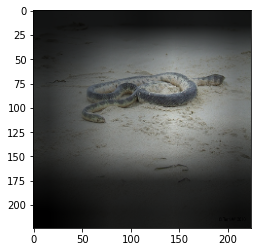

In [ ]:
%%time

IMG_PATH = f'/content/drive/My Drive/input/cams/ILSVRC2012_val_00000001.JPEG'

img = io.imread(IMG_PATH)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = prepare_input(img)
model = models.mobilenet_v2(pretrained=True)

layer_name = get_last_conv_name(model)
print(layer_name)
mask, conf = grad_cam(model, None, layer_name = layer_name, input = input) # cam mask
print("conf: ", round(conf, 4))
print(mask.shape)
E_c, _ = gen_cam(img, mask)

imgplot = plt.imshow(E_c)
